In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.latent_gan import LatentGAN

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, \
                                    point_cloud_distances, jensen_shannon_divergence, sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere


from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator, latent_code_generator

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
n_pc_samples = 2048
do_training = True
do_plotting = True
ae_loss = 'emd'

save_synthetic_samples = True
save_model = True

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]

experiment_name = 'ae_'+ ae_loss + '_' + class_name + '_' + str(n_pc_samples) +  '_pts'

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/ae_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.
car


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_emd_car_2048_pts'

In [11]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

7497 files containing complete point clouds were found.


In [13]:
# Load Auto-Encoder
reset_tf_graph()

ae_net_name = class_name + '_conv_arch_1_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))

ae = PointNetAutoEncoder(ae_net_name, ae_conf)
saved_epochs = read_saved_epochs(ae_conf.train_dir)
last_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 1000.


In [14]:
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
training_data = PointCloudDataSet(latent_codes)

In [15]:
init_lr = 0.0005
batch_size = 50

noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = 512
max_epochs = 50

n_syn_samples = training_data.num_examples  # Same number as original GT data.
n_out = [latent_codes.shape[1]]
accum_syn_data = []
train_stats = []

reset_tf_graph()
gan = LatentGAN(experiment_name, init_lr, n_out, noise_dim, latent_code_discriminator, latent_code_generator)

In [16]:
if do_training:
    for _ in range(max_epochs):        
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss
        syn_latent_data = gan.generate(n_syn_samples, noise_params)
        syn_data = ae.decode(syn_latent_data)
        accum_syn_data.append(syn_data)                
        if save_model:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        train_stats.append((epoch,) + loss)

1 (1.2598342287460429, 1.3231548798964328)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_emd_car_2048_pts/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
2 (1.2173032112569617, 1.2456593617496874)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_emd_car_2048_pts/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.
3 (1.1785591292701312, 1.2116603723308383)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_emd_car_2048_pts/models.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.
4 (1.2019630830559955, 1.1646855013482522)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_emd_car_2048_pts/models.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.
5 (1.2312837367089802, 1.0751344205549098)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/

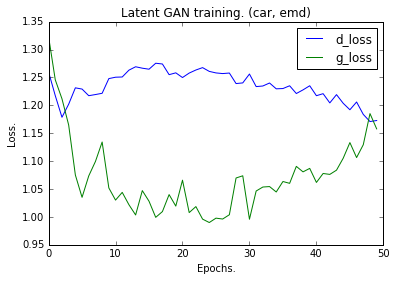

In [ ]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [ ]:
if save_synthetic_samples:
    save_dir = osp.join(synthetic_data_out_dir, experiment_name)
    create_dir(save_dir)
    epochs_to_save = range(0, 50, 1)
    for i in epochs_to_save:
        np.savez(osp.join(save_dir, 'epoch_' + str(i+1)), accum_syn_data[i])

In [ ]:
epoch_to_check = 5
n_check = 5
check_data = accum_syn_data[epoch_to_check-1]
rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)

for i in range(n_check):
    Point_Cloud(check_data[rids[i]]).plot()